# Calculate robusteness from pi control runs

In [305]:
# Some definitions

# directory of data
#fdir = '~/Google Drive/professional/research/FARALLON_INSTITUTE_PROJECTS/2020 NOAA MAPP/Climate_extremes_sharedfigsandcode/data/FOR SCATTER PLOT/'
fdir = '/Volumes/GoogleDrive/My Drive/Climate_extremes_sharedfigsandcode/data/Annual_TimeSeries/'

In [306]:
# Modules
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore') #filter some warning messages
import seaborn as sns

In [307]:
#detrend function: detrend use polynomial fit
def detrend(x,y,degree):
    import statsmodels.formula.api as smf
    import numpy as np
    import pandas as pd
    

    df = pd.DataFrame(columns=['y', 'x'])
    df['x'] = x
    df['y'] = pd.Series(y)   #y

    idx = np.isfinite(x) & np.isfinite(y)
    weights = np.polyfit(x[idx], y[idx], degree)
    model = np.poly1d(weights)
    results = smf.ols(formula='y ~ model(x)', data=df).fit()

    p_value=results.f_pvalue
    r2=results.rsquared_adj

    detrend_ts=np.zeros(shape=(len(y),))
    detrend_ts[:] = np.nan
    detrend_ts[idx]=y[idx]-results.fittedvalues

    #plt.figure(figsize=(10,4))
    #plt.plot(x,y)
    #plt.plot(x[idx], results.fittedvalues, 'r')
    #plt.figure(figsize=(10,4))
    #plt.plot(x, detrend_ts)
    #plt.show()

    return p_value, r2, detrend_ts

In [308]:
def num_coevents(y1, y2, ny, pct1, pct2, runs='picontrol',loc='cclme'):
    # 
    fin1 = fdir+'original ts/'+runs+'_'+loc+'_sst.nc'
    fin2 = fdir+'original ts/'+runs+'_sm.nc'
    modsst = xr.open_dataset(fin1)
    modsst.close()
    modsm2 = xr.open_dataset(fin2)
    modsm2.close()
    
    models = modsm2.model

    # selec periood
    modsst = modsst.sel(year=slice(y1,y2))
    modsm2 = modsm2.sel(year=slice(y1,y2))

    nev = list()
    mhw = list()
    drt = list()    
    for ix,i in enumerate(models):
        #print(ix,i)
        tmp1_0= modsst.sel(model=i).sst.values
        tmp2_0= modsm2.sel(model=i).sm.values
        
        #detrend
        nsample = np.linspace(1,len(tmp1_0), len(tmp1_0))
        [p_value, r2, tmp1]= detrend(nsample,tmp1_0,1)
        nsample = np.linspace(1,len(tmp2_0), len(tmp2_0))
        [p_value, r2, tmp2]= detrend(nsample,tmp2_0,1)
        
        # calculate threshold
        mhw_thr = np.nanpercentile(tmp1,pct1)
        drg_thr = np.nanpercentile(tmp2,pct2)
    
        a1 = tmp1>=mhw_thr
        a2 = tmp2<=drg_thr
        
        tmp = np.full((len(modsst.year.values),1),1)
        tmp = tmp[a1*a2]
        
        tmp1 = np.full((len(modsst.year.values),1),1)
        tmp1 = tmp1[a1]
        tmp2 = np.full((len(modsst.year.values),1),1)
        tmp2 = tmp2[a2]
        
        nev.append(len(tmp)/ny*100) #/(y2-y1+1)) #freq.
        mhw.append(len(tmp1)/ny*100)  #mhw_thr)#
        drt.append(len(tmp2)/ny*100)  #drg_thr)#   
    return nev , mhw, drt # sum(nev)

In [309]:
ny = 30
prc1 = 90
prc2 = 10
loc='cclme'

pinev=list()
pim=list()
pid=list()
for i in range(int(500/ny)):
    nev,m0,d0 = num_coevents(i*ny+1, (i+1)*ny, ny,prc1 , prc2,loc=loc)
    pinev.append(nev)
    pim.append(m0)
    pid.append(d0)
pinev,np.mean(pinev) ,np.mean(pim), np.mean(pid) 

([[3.3333333333333335,
   0.0,
   0.0,
   3.3333333333333335,
   0.0,
   0.0,
   0.0,
   0.0,
   3.3333333333333335,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   6.666666666666667,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0],
  [0.0,
   0.0,
   3.3333333333333335,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   6.666666666666667,
   0.0,
   0.0,
   3.3333333333333335,
   0.0,
   0.0,
   3.3333333333333335,
   3.3333333333333335,
   0.0,
   3.3333333333333335,
   3.3333333333333335,
   3.3333333333333335,
   0.0,
   0.0],
  [0.0,
   0.0,
   3.3333333333333335,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   3.3333333333333335,
   0.0,
   0.0,
   3.3333333333333335,
   0.0,
   0.0,
   0.0],
  [0.0,
   0.0,
   3.3333333333333335,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   3.3333333333333335,
   0.0,
   0.0,
   3.3333333333333335,
   3.3333333333333335,
   0.0,
   0.0,
   0.0,
   0.0,
   3.3333333333333335,
   3.3333333333333335,
   0

In [310]:
#model by model

In [311]:
model_mean=np.mean(pinev,axis=0)
model_spread=np.std(pinev,axis=0)
IV=(np.sum((model_spread*model_spread))/22)**.5
IV,model_spread

(1.4178637990037168,
 array([1.86338998, 0.80687153, 1.61374306, 1.10239638, 0.80687153,
        0.        , 1.61374306, 1.94320397, 1.94320397, 1.10239638,
        1.61374306, 1.61374306, 1.44337567, 0.80687153, 2.03058216,
        1.30104125, 1.86338998, 1.30104125, 1.61374306, 1.44337567,
        0.        , 0.80687153]))

In [312]:
#16 30-yr periods MMEs

In [313]:
mme_mean=np.mean(pinev,axis=1)
mme_spread=np.std(pinev,axis=1)
#internal variability mean and spread
mme_mean,np.mean(mme_spread)

(array([0.75757576, 1.36363636, 0.45454545, 0.90909091, 0.60606061,
        0.60606061, 0.45454545, 0.60606061, 0.75757576, 0.90909091,
        0.90909091, 1.06060606, 0.75757576, 0.3030303 , 0.90909091,
        0.3030303 ]),
 1.4314100328689787)

In [314]:
#MME mean and spread

In [315]:
mme_model_mean=np.mean(mme_mean)
mme_model_spread=np.std(mme_mean)
mme_model_mean,mme_model_spread

(0.7291666666666666, 0.27429447647651967)

In [316]:
#cross model mean and spread

In [317]:
cross_model_mean=np.mean(model_mean)
cross_model_spread=np.std(model_mean)
cross_model_mean,cross_model_spread

(0.7291666666666667, 0.45187425342576326)

In [318]:
IV,cross_model_spread,mme_model_spread,np.std(pinev),np.std(pinev)-IV

(1.4178637990037168,
 0.45187425342576326,
 0.27429447647651967,
 1.488129058057245,
 0.0702652590535282)

In [319]:
## Calculate thresholds for PI Control runs

In [320]:
def get_thre(loc,y1,y2,prc1,prc2):
    # open data: anomalies (without trend)

    modsst = xr.open_dataset(fdir+'original ts/picontrol_'+loc+'_sst.nc')
    modsst.close()
    modsm2 = xr.open_dataset(fdir+'original ts/picontrol_sm.nc')
    modsm2.close()

    # select period 
    modsst = modsst.sel(year=slice(y1,y2))
    modsm2 = modsm2.sel(year=slice(y1,y2))
    mhw_thr = list()
    drg_thr = list()
    models = list()

    # Calculate thresholds for each model
    for ix,i in enumerate(modsm2.model.values):
        tmp1_0= modsst.sel(model=i).sst.values
        tmp2_0= modsm2.sel(model=i).sm.values
        
        #detrend
        nsample = np.linspace(1,len(tmp1_0), len(tmp1_0))
        [p_value, r2, tmp1]= detrend(nsample,tmp1_0,1)
        nsample = np.linspace(1,len(tmp2_0), len(tmp2_0))
        [p_value, r2, tmp2]= detrend(nsample,tmp2_0,1)
        
        mhw_thr.append(np.nanpercentile(tmp1,prc1))
        drg_thr.append(np.nanpercentile(tmp2,prc2))

        models.append(i)
    
    return mhw_thr, drg_thr , models

In [321]:
# calculate number of events for control, historical and future
# based on pi control thresholds

def freq_coevents(fdir, runs, loc, mhw_thr, drg_thr, models, y1, y2):
    #pi control
    fi1 = fdir+'original ts/'+runs+'_'+loc+'_sst.nc'
    fi2 = fdir+'original ts/'+runs+'_sm.nc'
    modsst = xr.open_dataset(fi1)
    modsst.close()
    modsm2 = xr.open_dataset(fi2)
    modsm2.close()
    models=modsm2.model

    # select period
    modsst = modsst.sel(year=slice(y1,y2))
    modsm2 = modsm2.sel(year=slice(y1,y2))

    nev = list()
    drt=list()
    mhw=list()
    for ix,i in enumerate(models):
        #print(ix,i)
        tmp1_0= modsst.sel(model=i).sst.values
        tmp2_0= modsm2.sel(model=i).sm.values
        
        #detrend
        nsample = np.linspace(1,len(tmp1_0), len(tmp1_0))
        [p_value, r2, tmp1]= detrend(nsample,tmp1_0,1)
        nsample = np.linspace(1,len(tmp2_0), len(tmp2_0))
        [p_value, r2, tmp2]= detrend(nsample,tmp2_0,1)
        
        a1 = tmp1>=mhw_thr[ix]
        a2 = tmp2<=drg_thr[ix]
        tmp = np.full((len(modsst.year.values),1),1)
        tmp = tmp[a1*a2]
        
        tmp1 = np.full((len(modsst.year.values),1),1)
        tmp1 = tmp1[a1]
        tmp2 = np.full((len(modsst.year.values),1),1)
        tmp2 = tmp2[a2]
        
        nev.append(len(tmp)/30*100)
        mhw.append(len(tmp1)/30*100)
        drt.append(len(tmp2)/30*100)
    
    freq = np.array(nev) #/(y2-y1+1)
    
    return nev,  mhw, drt #mean no. of events
#freq, np.round(np.nanmean(freq),4), np.round(np.nanstd(freq),4) #mean frequency


In [322]:
def freq_difruns(loc,ny, y0,y,prc1, prc2):
    
    # calculate threshold in pi control
    #y2=2014
    #y1=y2-ny+1
    mhw_thr, drg_thr, models = get_thre(loc,y0,y,prc1,prc2)

    print ('Percentiles: '+str(prc1)+'/'+str(prc2))
    # pi control
    print('piControl: '+str(y0)+'-'+str(y))
    #y2=2014
    #y1=y2-ny+1
    freq0, mfrq, sfrq = freq_coevents(fdir,'picontrol',loc, mhw_thr,drg_thr, models,y0,y)
    print(mfrq,sfrq)

    # historical 1
    y1 = 1900
    y2 = y1+ny-1
    print('\nhistorical: '+str(y1)+'-'+str(y2))
    freq, mfrq, sfrq = freq_coevents(fdir,'historical',loc,mhw_thr,drg_thr, models, y1,y2)
    print(mfrq,sfrq)

    # historical 2
    y2=2029
    y1=y2-ny+1
    print('\nhistorical 2: '+str(y1)+'-'+str(y2))
    freq1, mfrq1, sfrq1 = freq_coevents(fdir,'histssp585',loc,mhw_thr,drg_thr, models, y1,y2)
    print(mfrq1,sfrq1)


    # historical 2
    y2=2014
    y1=y2-ny+1
    print('\nhistorical 2: '+str(y1)+'-'+str(y2))
    freq, mfrq, sfrq = freq_coevents(fdir,'historical',loc,mhw_thr,drg_thr, models, y1,y2)
    print(mfrq,sfrq)

    # future 1
    y2=2099
    y1=y2-ny+1
    print('\nfuture: '+str(y1)+'-'+str(y2))
    freq2, mfrq2, sfrq2 = freq_coevents(fdir,'ssp585',loc,mhw_thr,drg_thr, models, y1,y2)
    print(mfrq2,sfrq2)
    
    # future 2
    y2=2069
    y1=y2-ny+1
    print('\nfuture: '+str(y1)+'-'+str(y2))
    freq, mfrq, sfrq = freq_coevents(fdir,'ssp585',loc,mhw_thr,drg_thr, models, y1,y2)
    print(mfrq,sfrq)

    # future 2
    y2=2044
    y1=y2-ny+1
    print('\nfuture: '+str(y1)+'-'+str(y2))
    freq, mfrq, sfrq = freq_coevents(fdir,'ssp585',loc,mhw_thr,drg_thr, models, y1,y2)
    print(mfrq,sfrq)
    
    return freq0,freq1,freq2,mfrq1, sfrq1,mfrq2, sfrq2

In [323]:
# Frequency of events - detrended data, using pi control threshols
## percentiles 90-10

In [324]:

print ('\nPercentiles: '+str(prc1)+'/'+str(prc2))
print('\nProbable # events in '+str(ny)+' years'+': '+str(ny*0.01))
funev=list()
hinev=list()
test=list()
him=list()
hid=list()
fum=list()
fud=list()
for i in range(int(500/ny)):
    pi,hi,fu,m1,d1,m2,d2 = freq_difruns(loc,ny,i*ny+1, (i+1)*ny, prc1, prc2)
    test.append(pi)
    funev.append(fu)
    hinev.append(hi)
    him.append(m1)
    hid.append(d1)
    fum.append(m2)
    fud.append(d2)
np.mean(funev),np.mean(hinev),np.mean(him),np.mean(hid),np.mean(fum),np.mean(fud)


Percentiles: 90/10

Probable # events in 30 years: 0.3
Percentiles: 90/10
piControl: 1-30
[10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0] [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]

historical: 1900-1929
[3.3333333333333335, 20.0, 13.333333333333334, 13.333333333333334, 3.3333333333333335, 6.666666666666667, 20.0, 3.3333333333333335, 13.333333333333334, 6.666666666666667, 3.3333333333333335, 13.333333333333334, 10.0, 23.333333333333332, 23.333333333333332, 13.333333333333334, 23.333333333333332, 16.666666666666664, 10.0, 13.333333333333334, 6.666666666666667, 13.333333333333334] [13.333333333333334, 6.666666666666667, 13.333333333333334, 10.0, 26.666666666666668, 33.33333333333333, 13.333333333333334, 16.666666666666664, 16.666666666666664, 0.0, 23.333333333333332, 3.3333333333333335, 23.333333333333332, 20.0, 3.

[10.0, 6.666666666666667, 20.0, 20.0, 23.333333333333332, 6.666666666666667, 3.3333333333333335, 20.0, 3.3333333333333335, 10.0, 6.666666666666667, 0.0, 6.666666666666667, 6.666666666666667, 0.0, 23.333333333333332, 6.666666666666667, 20.0, 6.666666666666667, 13.333333333333334, 10.0, 20.0] [0.0, 23.333333333333332, 6.666666666666667, 10.0, 6.666666666666667, 3.3333333333333335, 6.666666666666667, 6.666666666666667, 10.0, 6.666666666666667, 3.3333333333333335, 0.0, 3.3333333333333335, 10.0, 16.666666666666664, 6.666666666666667, 3.3333333333333335, 10.0, 6.666666666666667, 10.0, 20.0, 13.333333333333334]
Percentiles: 90/10
piControl: 61-90
[10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0] [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]

historical: 1900-1929
[6.666666666666667, 20.0, 13.333333333333334, 16.66666666666666

[13.333333333333334, 16.666666666666664, 10.0, 3.3333333333333335, 16.666666666666664, 10.0, 13.333333333333334, 13.333333333333334, 13.333333333333334, 16.666666666666664, 16.666666666666664, 3.3333333333333335, 16.666666666666664, 3.3333333333333335, 3.3333333333333335, 0.0, 6.666666666666667, 6.666666666666667, 10.0, 23.333333333333332, 16.666666666666664, 13.333333333333334] [16.666666666666664, 13.333333333333334, 3.3333333333333335, 16.666666666666664, 16.666666666666664, 10.0, 10.0, 13.333333333333334, 26.666666666666668, 30.0, 23.333333333333332, 30.0, 16.666666666666664, 10.0, 23.333333333333332, 13.333333333333334, 3.3333333333333335, 16.666666666666664, 20.0, 20.0, 13.333333333333334, 10.0]

future: 2015-2044
[10.0, 6.666666666666667, 3.3333333333333335, 0.0, 10.0, 10.0, 10.0, 16.666666666666664, 10.0, 10.0, 20.0, 0.0, 20.0, 3.3333333333333335, 6.666666666666667, 13.333333333333334, 6.666666666666667, 16.666666666666664, 6.666666666666667, 16.666666666666664, 3.3333333333333

[13.333333333333334, 3.3333333333333335, 3.3333333333333335, 3.3333333333333335, 23.333333333333332, 13.333333333333334, 13.333333333333334, 6.666666666666667, 10.0, 20.0, 16.666666666666664, 3.3333333333333335, 6.666666666666667, 0.0, 6.666666666666667, 0.0, 10.0, 16.666666666666664, 23.333333333333332, 6.666666666666667, 33.33333333333333, 16.666666666666664] [16.666666666666664, 20.0, 13.333333333333334, 23.333333333333332, 10.0, 13.333333333333334, 6.666666666666667, 30.0, 23.333333333333332, 20.0, 10.0, 6.666666666666667, 10.0, 10.0, 30.0, 3.3333333333333335, 10.0, 10.0, 6.666666666666667, 20.0, 26.666666666666668, 10.0]

future: 2015-2044
[16.666666666666664, 3.3333333333333335, 0.0, 0.0, 16.666666666666664, 13.333333333333334, 16.666666666666664, 10.0, 3.3333333333333335, 10.0, 20.0, 3.3333333333333335, 10.0, 0.0, 6.666666666666667, 3.3333333333333335, 6.666666666666667, 20.0, 16.666666666666664, 0.0, 10.0, 10.0] [3.3333333333333335, 23.333333333333332, 13.333333333333334, 10.0,

[13.333333333333334, 16.666666666666664, 3.3333333333333335, 23.333333333333332, 30.0, 13.333333333333334, 10.0, 13.333333333333334, 10.0, 23.333333333333332, 10.0, 6.666666666666667, 6.666666666666667, 3.3333333333333335, 6.666666666666667, 0.0, 20.0, 3.3333333333333335, 10.0, 23.333333333333332, 23.333333333333332, 16.666666666666664] [10.0, 13.333333333333334, 13.333333333333334, 16.666666666666664, 16.666666666666664, 30.0, 13.333333333333334, 20.0, 23.333333333333332, 30.0, 20.0, 30.0, 16.666666666666664, 6.666666666666667, 20.0, 6.666666666666667, 10.0, 6.666666666666667, 6.666666666666667, 23.333333333333332, 23.333333333333332, 13.333333333333334]

future: 2015-2044
[13.333333333333334, 6.666666666666667, 0.0, 13.333333333333334, 26.666666666666668, 13.333333333333334, 6.666666666666667, 16.666666666666664, 0.0, 10.0, 13.333333333333334, 16.666666666666664, 16.666666666666664, 3.3333333333333335, 6.666666666666667, 6.666666666666667, 10.0, 16.666666666666664, 6.666666666666667,

[13.333333333333334, 3.3333333333333335, 13.333333333333334, 30.0, 13.333333333333334, 6.666666666666667, 0.0, 13.333333333333334, 13.333333333333334, 20.0, 10.0, 3.3333333333333335, 26.666666666666668, 6.666666666666667, 3.3333333333333335, 0.0, 10.0, 6.666666666666667, 20.0, 3.3333333333333335, 20.0, 16.666666666666664] [20.0, 20.0, 3.3333333333333335, 16.666666666666664, 16.666666666666664, 13.333333333333334, 6.666666666666667, 16.666666666666664, 23.333333333333332, 20.0, 36.666666666666664, 10.0, 13.333333333333334, 26.666666666666668, 23.333333333333332, 3.3333333333333335, 6.666666666666667, 10.0, 3.3333333333333335, 20.0, 16.666666666666664, 13.333333333333334]

future: 2015-2044
[10.0, 3.3333333333333335, 20.0, 20.0, 6.666666666666667, 6.666666666666667, 0.0, 20.0, 10.0, 10.0, 10.0, 3.3333333333333335, 20.0, 6.666666666666667, 3.3333333333333335, 10.0, 6.666666666666667, 16.666666666666664, 10.0, 0.0, 3.3333333333333335, 10.0] [3.3333333333333335, 23.333333333333332, 6.666666

[6.666666666666667, 6.666666666666667, 3.3333333333333335, 10.0, 20.0, 10.0, 16.666666666666664, 6.666666666666667, 6.666666666666667, 13.333333333333334, 16.666666666666664, 16.666666666666664, 13.333333333333334, 13.333333333333334, 16.666666666666664, 10.0, 3.3333333333333335, 10.0, 3.3333333333333335, 10.0, 0.0, 16.666666666666664] [10.0, 13.333333333333334, 16.666666666666664, 20.0, 16.666666666666664, 13.333333333333334, 26.666666666666668, 20.0, 16.666666666666664, 10.0, 0.0, 3.3333333333333335, 13.333333333333334, 16.666666666666664, 23.333333333333332, 23.333333333333332, 10.0, 16.666666666666664, 3.3333333333333335, 10.0, 13.333333333333334, 16.666666666666664]

future: 2040-2069
[13.333333333333334, 13.333333333333334, 3.3333333333333335, 6.666666666666667, 26.666666666666668, 16.666666666666664, 10.0, 13.333333333333334, 10.0, 20.0, 13.333333333333334, 16.666666666666664, 6.666666666666667, 10.0, 13.333333333333334, 0.0, 6.666666666666667, 3.3333333333333335, 10.0, 3.333333

[6.666666666666667, 6.666666666666667, 10.0, 26.666666666666668, 13.333333333333334, 23.333333333333332, 10.0, 6.666666666666667, 3.3333333333333335, 16.666666666666664, 10.0, 26.666666666666668, 13.333333333333334, 10.0, 16.666666666666664, 20.0, 0.0, 16.666666666666664, 13.333333333333334, 16.666666666666664, 30.0, 6.666666666666667] [3.3333333333333335, 16.666666666666664, 16.666666666666664, 16.666666666666664, 13.333333333333334, 10.0, 13.333333333333334, 23.333333333333332, 0.0, 16.666666666666664, 6.666666666666667, 3.3333333333333335, 20.0, 6.666666666666667, 16.666666666666664, 10.0, 13.333333333333334, 3.3333333333333335, 13.333333333333334, 6.666666666666667, 30.0, 20.0]

future: 2070-2099
[6.666666666666667, 26.666666666666668, 10.0, 13.333333333333334, 10.0, 6.666666666666667, 20.0, 10.0, 0.0, 16.666666666666664, 3.3333333333333335, 16.666666666666664, 13.333333333333334, 0.0, 16.666666666666664, 16.666666666666664, 6.666666666666667, 10.0, 10.0, 10.0, 6.666666666666667, 1

[16.666666666666664, 3.3333333333333335, 13.333333333333334, 30.0, 6.666666666666667, 33.33333333333333, 6.666666666666667, 10.0, 10.0, 6.666666666666667, 10.0, 6.666666666666667, 16.666666666666664, 3.3333333333333335, 13.333333333333334, 20.0, 3.3333333333333335, 13.333333333333334, 16.666666666666664, 30.0, 26.666666666666668, 16.666666666666664] [13.333333333333334, 13.333333333333334, 0.0, 23.333333333333332, 10.0, 6.666666666666667, 6.666666666666667, 23.333333333333332, 20.0, 0.0, 3.3333333333333335, 10.0, 6.666666666666667, 23.333333333333332, 3.3333333333333335, 13.333333333333334, 6.666666666666667, 13.333333333333334, 10.0, 3.3333333333333335, 16.666666666666664, 13.333333333333334]

historical 2: 1985-2014
[10.0, 6.666666666666667, 10.0, 26.666666666666668, 10.0, 33.33333333333333, 10.0, 3.3333333333333335, 3.3333333333333335, 16.666666666666664, 16.666666666666664, 10.0, 20.0, 10.0, 16.666666666666664, 16.666666666666664, 0.0, 6.666666666666667, 13.333333333333334, 20.0, 2

(1.1174242424242424,
 0.9280303030303031,
 12.367424242424244,
 13.058712121212123,
 11.15530303030303,
 13.001893939393938)

In [325]:
loc,ny

('cclme', 30)

In [326]:
N=int(500/ny)
N

16

In [327]:
np.mean(model_mean),np.mean(hinev),np.mean(funev)

(0.7291666666666667, 0.9280303030303031, 1.1174242424242424)

In [328]:
import statsmodels.api as sm
import statsmodels as sm
import pandas
from patsy import dmatrices

In [329]:
import numpy as np
import scipy.stats


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [330]:
#future - picontrol FAR
diff=list()
for k in range(len(pinev)):
    zip_obj=zip(funev[k],pinev[k])
    for i , j in zip_obj:
            diff.append(i-j)
    #diff mean, model spread
diff_a=np.asarray(diff).reshape(N,22)
diff_mean=np.mean(diff_a,axis=1)
diff_spread=np.std(diff_mean)
diff_mean.mean(),diff_spread

(0.38825757575757575, 0.4966853803766423)

In [331]:
hinev_a=np.asarray(funev).reshape(N,22).sum(axis=1)
pinev_a=np.asarray(pinev).reshape(N,22).sum(axis=1)
far=(hinev_a-pinev_a)/hinev_a
FAR=np.mean(far)
sd=np.std(far)
FAR,sd,mean_confidence_interval(far)

(0.24880952380952384,
 0.44223005877780547,
 (0.24880952380952384, 0.0054335591961852114, 0.49218548842286247))

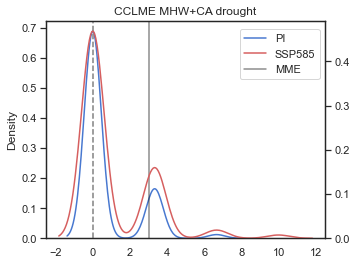

In [367]:
import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True)
fig, ax1 = plt.subplots(figsize=(5,4))

#for i in range(nmdl):
#    lbl=mdl_list[i]
#    ax1=sns.distplot(np.asarray(pinev).reshape(N,22)[:,i],  hist=False, kde_kws={"label": lbl })  #, ax=axes[0, 0])

ax1=sns.distplot(np.asarray(pinev), bins=10,hist=False,color='b',label='PI')  #, ax=axes[0, 0])hist=False,
#ax1.set_ylim([0,.6])

ax2 = ax1.twinx()
ax2=sns.distplot(np.asarray(funev), bins=10,hist=False,color='r',label='SSP585')  #, ax=axes[0, 0])
#ax2.set_ylim([0,0.02])
ax2.set_ylabel('')

plt.axvline(x=0,linestyle='--',color='gray',zorder=0)
diff_mean=np.mean(diff_a,axis=1)
diff_spread=np.std(diff_mean)
plt.axvline(x=diff_mean.mean(),color='k',alpha=.5,label='MME',zorder=0)
#plt.errorbar(diff_mean.mean(), .01, xerr=diff_spread,color='r')
fig.legend(bbox_to_anchor=(.9, .87))
plt.title(loc.upper()+' MHW+CA drought')    
plt.show()

In [361]:
print(stats.kstest( fucdf,picdf))#,alternative='greater'))

KstestResult(statistic=0.3, pvalue=0.7869297884777761)


In [333]:
from scipy import stats
x=np.asarray(funev).flatten()
y=np.asarray(pinev).flatten()
print(stats.kstest( x,y))#,alternative='greater'))
print(stats.mannwhitneyu(x,y,alternative='greater'))

KstestResult(statistic=0.07954545454545454, pvalue=0.21555662198497114)
MannwhitneyuResult(statistic=67144.0, pvalue=0.005005320972954868)


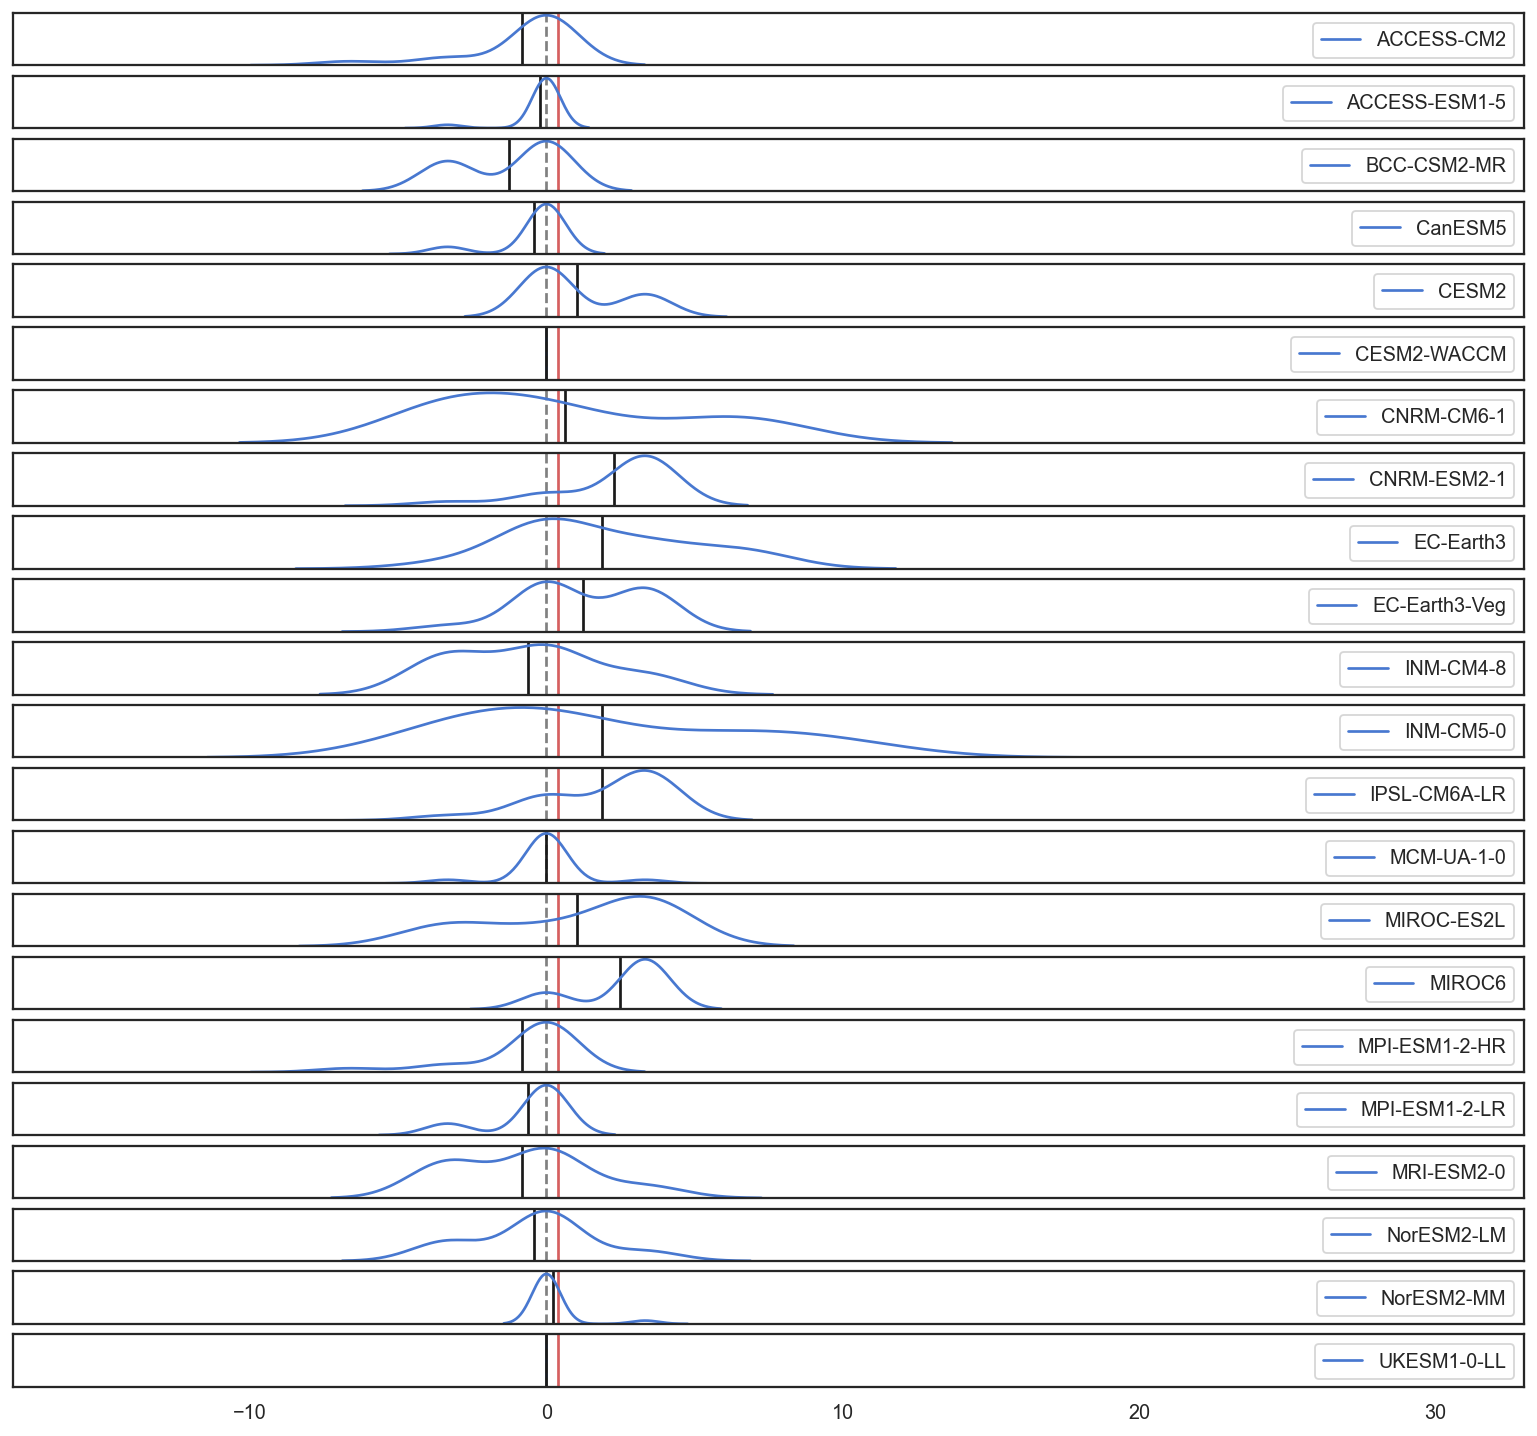

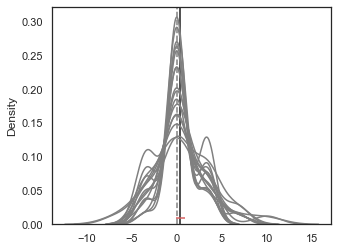

In [334]:
import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True)

plt.figure(figsize=(15,14),dpi=130)
nmdl=22
mdl_list=['ACCESS-CM2',    'ACCESS-ESM1-5',  'BCC-CSM2-MR',   'CanESM5',  'CESM2',  
         'CESM2-WACCM',  'CNRM-CM6-1',  'CNRM-ESM2-1',  'EC-Earth3',  'EC-Earth3-Veg',   
         'INM-CM4-8',  'INM-CM5-0',  'IPSL-CM6A-LR',  'MCM-UA-1-0',  'MIROC-ES2L',  'MIROC6', 
        'MPI-ESM1-2-HR',  'MPI-ESM1-2-LR',  'MRI-ESM2-0',  'NorESM2-LM',  'NorESM2-MM',  'UKESM1-0-LL']
for i in range(nmdl):
    ax = plt.subplot(22,1,i+1)
    lbl=mdl_list[i]
    fig=sns.distplot(diff_a[:,i],  hist=False, kde_kws={"label": lbl })  #, ax=axes[0, 0])
    if diff_a[:,i].std() ==0:
        plt.axvline(x=diff_a[:,i].mean(),color='b',label=lbl,zorder=0)

    plt.axvline(x=0,linestyle='--',color='gray',zorder=0)
    diff_mean=np.mean(diff_a,axis=0)
    diff_spread=np.std(diff_mean)
    plt.axvline(x=diff_mean[i],color='k',zorder=0)
    plt.axvline(x=diff_mean.mean(),color='r',zorder=0)
    plt.xlim([-18,33])
    plt.yticks([])
    plt.ylabel("")
    plt.legend()#loc='center left', bbox_to_anchor=(-0.7, .5))
lower_error = diff_mean.mean()-diff_spread
upper_error = diff_mean.mean()+diff_spread
#plt.errorbar(diff_mean.mean(), .1, xerr=diff_spread,color='k')
#print(diff_mean.mean(),diff_spread)
#plt.yscale('log')
#plt.legend(fontsize=8,loc='upper right', bbox_to_anchor=(1.5, .9))  
#plt.ylabel('density')
plt.show()


plt.figure(figsize=(5,4))
for k in range(N):
    fig=sns.distplot(diff_a[k,:], hist=False,color='gray')  #, ax=axes[0, 0])
plt.axvline(x=0,linestyle='--',color='gray',zorder=0)
diff_mean=np.mean(diff_a,axis=1)
diff_spread=np.std(diff_mean)
plt.axvline(x=diff_mean.mean(),color='k',zorder=0)
plt.errorbar(diff_mean.mean(), .01, xerr=diff_spread,color='r')
    
plt.show()



In [335]:
diff_d=np.asarray(funev).reshape(N,22).mean(axis=0)-np.asarray(pinev).reshape(N,22).mean(axis=0)
if diff_d.mean()>0:
    print(len(diff_d[diff_d>0])/22)
if diff_d.mean()<0:
    print(len(diff_d[diff_d<0])/22)
diff_d.mean()

0.45454545454545453


0.3882575757575758

In [336]:
#individual extremes

In [337]:
np.mean(him),np.mean(fum),np.mean(hid),np.mean(fud)

(12.367424242424244, 11.15530303030303, 13.058712121212123, 13.001893939393938)

In [338]:
diff=list()
for k in range(len(pinev)):
    zip_obj=zip(fum[k],pim[k])
    for i , j in zip_obj:
            diff.append(i-j)
    #diff mean, model spread
diff_a=np.asarray(diff).reshape(N,22)
diff_mean=np.mean(diff_a,axis=1)
diff_spread=np.std(diff_mean)
diff_mean.mean(),diff_spread

(1.15530303030303, 0.6981935072411652)

In [339]:
him_a=np.asarray(fum).reshape(N,22).sum(axis=1)
pim_a=np.asarray(pim).reshape(N,22).sum(axis=1)
far=(him_a-pim_a)/him_a
FAR=np.mean(far)
sd=np.std(far)
FAR=np.mean(far)
cu,cl=sm.stats.proportion.proportion_confint(FAR, 1, alpha=0.05, method='normal') #'binom_test''normal'
FAR,cu,cl,sd,mean_confidence_interval(far)

(0.10026447437908474,
 0.0,
 0.6889441828065289,
 0.052994987148955154,
 (0.10026447437908474, 0.07109932411161099, 0.1294296246465585))

In [340]:
him_a=np.asarray(fud).reshape(N,22).sum(axis=1)
pim_a=np.asarray(pid).reshape(N,22).sum(axis=1)
far=(him_a-pim_a)/him_a
FAR=np.mean(far)
sd=np.std(far)
FAR=np.mean(far)
cu,cl=sm.stats.proportion.proportion_confint(FAR, 1, alpha=0.05, method='normal') #'binom_test''normal'
FAR,cu,cl,sd,mean_confidence_interval(far)

(0.2224489849197725,
 0.0,
 1.0,
 0.08468601170857062,
 (0.2224489849197725, 0.17584306255033572, 0.2690549072892093))

In [341]:
diff=list()
for k in range(len(pinev)):
    zip_obj=zip(fud[k],pid[k])
    for i , j in zip_obj:
            diff.append(i-j)
    #diff mean, model spread
diff_a=np.asarray(diff).reshape(N,22)
diff_mean=np.mean(diff_a,axis=1)
diff_spread=np.std(diff_mean)
diff_mean.mean(),diff_spread

(3.001893939393939, 1.3058227983422326)